# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# Define environment
env = UnityEnvironment(file_name="Data/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Train the agent

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
# Tracking
!pip install wandb
!pip install jovian
!pip install --upgrade protobuf

import wandb
import jovian
import glob

You should consider upgrading via the '/home/manu/.conda/envs/drlnd/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/manu/.conda/envs/drlnd/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/manu/.conda/envs/drlnd/bin/python -m pip install --upgrade pip' command.


In [5]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

from maddpg import MADDPG

%matplotlib inline

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [7]:
agents = MADDPG(state_size, action_size)

max_episodes = 4000

# Scores of all episodes for plotting
scores = []
# Last 100 scores
scores_windows = deque(maxlen=100)
# Timestep
t_step = 1

# Play episodes
for episode in range(max_episodes):
    # Init episode
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    score = np.zeros(num_agents)
    
    # Play all timestep
    while True:
        # Get actions
        actions = agents.act(states)
        # Play step
        env_info = env.step(actions)[brain_name]
        # Retrieve step information
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        score += rewards
        agents.step(states, actions, rewards, next_states, dones, t_step)
        states = next_states
        
        t_step += 1
        
        if np.any(dones):
            break
        
    scores.append(score)
    scores_windows.append(score)
    wandb.log({'score': score,
      "mean last 100 scores": np.mean(scores_windows)})   

    print('\rEpisode {}  Average100 Score: {:.4f}'.format(episode, np.mean(scores_windows)), end="")
        
    if (episode + 1) % 100 == 0:
        print(f"\nEpisodes {episode}\tAverage score: {np.mean(scores_windows):.2f}\tScore: {np.mean(score):.2f}\n")
    
    # If the scorev of 0.5 is reached in last 100 episodes it's finish
    if np.mean(scores_windows) > 0.5:  
        print(f"\nEnvironment solved in {episode} episodes.\tAverage score is {np.mean(scores_windows):.2f}")
        agents.save() 
    
        jovian.log_metrics({"number episode resolved": episode,
               "Last 100 score": np.mean(scores_windows)})
        # python files
        py_files = glob.glob("*.py")
        py_files.append("Tennis.ipynb")
        # Parameters saved files
        pth_files = glob.glob("save/*")
        jovian.commit(project=agents.get_project_name(), message=agents.get_model_name(), environment=None, 
                      files=py_files, output=pth_files)
        break
        
env.close()

wandb: Currently logged in as: batmanu (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[jovian] Hyperparams logged.
Episode 99  Average100 Score: 0.00644
Episodes 99	Average score: 0.01	Score: -0.00

Episode 199  Average100 Score: 0.2019
Episodes 199	Average score: 0.20	Score: 1.20

Episode 290  Average100 Score: 0.5000
Environment solved in 290 episodes.	Average score is 0.50
... Saving checkpoint ...
... Saving checkpoint ...
... Saving checkpoint ...
... Saving checkpoint ...
... Saving checkpoint ...
... Saving checkpoint ...
... Saving checkpoint ...
... Saving checkpoint ...
[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "manu-farcy/rl-cooperative-tennis" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/manu-farcy/rl-cooperative-tennis


Text(0.5, 0, 'Episode #')

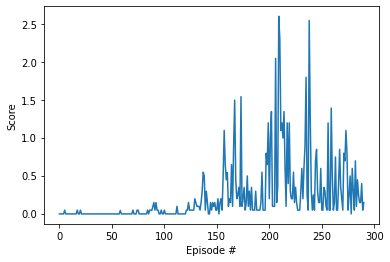

In [8]:
import matplotlib.pyplot as plt
scores_mean = np.mean(np.asarray(scores), axis=1)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')

# Let's play the agents

In [ ]:

from unityagents import UnityEnvironment

import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from maddpg import MADDPG

from collections import deque


# Load environment
env = UnityEnvironment(file_name="Data/Tennis_Linux/Tennis.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
    
action_size = brain.vector_action_space_size
state_size = states.shape[1]

# Create new agents
agents = MADDPG(state_size, action_size)
agents.load()

for episode in range(10):

    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations

    
    
    
    score = []
    while True:
        actions = agents.act(states)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        score.append(rewards)

        dones = env_info.local_done
        if np.any(dones):
            break

env.close()

print(f"Total score: {np.mean(score)}")